# K vizinhos mais próximos

Neste notebook vou demonstrar a utilização de um algoritmo de classificação chamado *K vizinhos mais próximos*.

Se trata de um dos modelos preditivos mais simples que existe. Sendo que não requer nenhuma noção de matemática muito profunda para compreender seu funcionamento e também é muito fácil de ser aplicado, sendo que tem poucos argumentos!

Porém, por um outro lado, o KNN não funciona bem com inputs categóricos ou com dimensionalidades muito altas, já que espaços de altas dimensões vão ficando cada vez mais vastos, e os vizinhos consequentemente ficando mais longe (isso pode não ser muito claro agora, mas me acompanhe que eu vou tentar explicar).

Mas bom, para deixar claro o que estou falando, vamos mostrar como funciona o KNN:

## A lógica por trás do KNN:

Antes de eu de fato começar a explicação, adianto que temos duas formas de aplicar o KNN, uma mais complicada, porém mais completa, e uma muito mais cômoda, vamos dizer assim. O que quero dizer é que podemos programar toda a lógica do KNN por meio de funções (e isso, na minha opinião, ajuda muito a entender o funcionamento do KNN), e também podemos usar o `scikit-learn` que já possui tudo pronto. E eu vou mostrar as duas formas.

Mas primeiro, vamos tentar entender o que o KNN faz e qual a lógica por trás:

Como eu disse anteriormente, o KNN é um **algoritmo de classificação**, ou também, comumente chamado de **clusterização**.

Ou seja, basicamente, imagine que tenhamos um *dataset* que contém uma amostra de 100 animais, 50 são gatos e 50 são cachorros, e nessa amostra nós temos o peso e comprimento de cada um desses animais. E agora, vamos supor que recebemos o dado de um outro animal, porém esse novo dado não veio com a classificação entre gato e cachorro, contém apenas o peso e o comprimento. O que o KNN tenta fazer é classificar o animal comparando o peso e o comprimento dele com a nossa amostra de 100 animais!

E como que isso é feito? É tudo feito através da distância euclidiana dos pontos! E vai ficar muito mais simples de entender através de exemplos:

In [1]:
# importando algumas libs que vou usar agora para a demonstração

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [2]:
cancer_de_prostata = pd.read_csv('Prostate_Cancer.csv') # Importando o dataset que usarei de exemplo

In [3]:
cancer_de_prostata.head(10)

,id,diagnosis_result,radius,texture,perimeter,area,smoothness,compactness,symmetry,fractal_dimension
0,1,M,23,12,151,954,0.143,0.278,0.242,0.079
1,2,B,9,13,133,1326,0.143,0.079,0.181,0.057
2,3,M,21,27,130,1203,0.125,0.160,0.207,0.060
3,4,M,14,16,78,386,0.070,0.284,0.260,0.097
4,5,M,9,19,135,1297,0.141,0.133,0.181,0.059
5,6,B,25,25,83,477,0.128,0.170,0.209,0.076
6,7,M,16,26,120,1040,0.095,0.109,0.179,0.057
7,8,M,15,18,90,578,0.119,0.165,0.220,0.075
8,9,M,19,24,88,520,0.127,0.193,0.235,0.074
9,10,M,25,11,84,476,0.119,0.240,0.203,0.082


In [4]:
cancer_de_prostata.describe()

,id,radius,texture,perimeter,area,smoothness,compactness,symmetry,fractal_dimension
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,50.500000,16.850000,18.230000,96.780000,702.880000,0.102730,0.126700,0.193170,0.064690
std,29.011492,4.879094,5.192954,23.676089,319.710895,0.014642,0.061144,0.030785,0.008151
min,1.000000,9.000000,11.000000,52.000000,202.000000,0.070000,0.038000,0.135000,0.053000
25%,25.750000,12.000000,14.000000,82.500000,476.750000,0.093500,0.080500,0.172000,0.059000
50%,50.500000,17.000000,17.500000,94.000000,644.000000,0.102000,0.118500,0.190000,0.063000
75%,75.250000,21.000000,22.250000,114.250000,917.000000,0.112000,0.157000,0.209000,0.069000
max,100.000000,25.000000,27.000000,172.000000,1878.000000,0.143000,0.345000,0.304000,0.097000


O que eu fiz acima foi importar um dataset que contém informações e diagnósticos de câncer de próstata. Temos a coluna *diagnosis_result* que nos fala se a massa é benigna ou maligna, e as outras colunas trazem informações sobre a massa presente na próstata. O que queremos fazer é o seguinte é classificar, apenas com base nas informações sobre a massa, se se trata de um tumor benigno ou maligno.

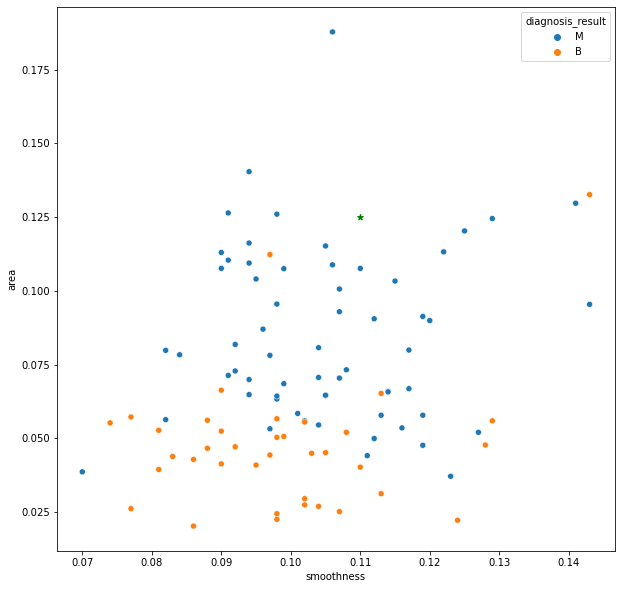

In [5]:
plt.figure(figsize=(10,10))
sns.scatterplot(
    x=cancer_de_prostata.smoothness,
    y=cancer_de_prostata.area/10000, # divido por mil porque a escala dos dados é muito diferente, entrarei em mais detalhes mais a frente
    hue=cancer_de_prostata.diagnosis_result
    )
plt.scatter(x=0.11, y=0.1250, color='g', marker='*') # destacando um novo ponto que queremos prever

Para explicar o funcionamento do KNN, imagine, para efeitos de simplificação (trazendo apenas duas dimensões para permitir a plotagem dos dados), que tenhamos apenas as duas características para cada tumor, demonstradas acima. E, que, tenhamos recebido um dado novo, o ponto verde, e queremos prever se estamos falando de um tumor benigno ou maligno...

Apenas olhando o gráfico é possível que consigamos assumir uma coisa: esse ponto verde está mais perto dos pontos azuis do que dos pontos laranjas, ou seja, isso nos diz que provavelmente estamos faladno de um tumor maligno. E o que o KNN faz é mais ou menos isso, só que de fato realizando cálculos e não apenas por observação!

O que o KNN faz é:

- Calcular a distância desse ponto verde para todos os outros pontos do gráfico
- Ordenar todas as distâncias em ordem crescente
- Pegar as K menores distâncias (ou seja, os K vizinhos mais próximos)
    - *Nós que escolhemos o K*
- Vê, dentre os K mais próximos, qual é a categoria mais comum
- Classifica o ponto verde de acordo com essa categoria mais comum

### Programando o KNN:

Agora vou programar a lógica do KNN para tentar tornar o entendimento mais concreto:

In [6]:
df = cancer_de_prostata[['id', 'diagnosis_result', 'area','smoothness']].copy()

In [7]:
df['area'] = df['area']/10000 #tentando deixar a variavel de área na mesma magnitude de smoothness
# para que a distancia euclidiana não fique tendenciosa em um eixo

In [8]:
df

,id,diagnosis_result,area,smoothness
0,1,M,0.0954,0.143
1,2,B,0.1326,0.143
2,3,M,0.1203,0.125
3,4,M,0.0386,0.070
4,5,M,0.1297,0.141
...,...,...,...,...
95,96,M,0.1264,0.091
96,97,B,0.0451,0.105
97,98,B,0.0295,0.102
98,99,B,0.0413,0.090


Obs.: Veja acima que eu dividi a coluna "Area" por 10000, e eu fiz isso para tentar aproximar a magnitude dos valores da coluna "Smoothness", por que a magnitude do valor "Area" originalmente é muito maior. Essa divisão por 10000 mil, em tese não é a metodologia correta para fazer o que chamamos de **normalização** e sem dúvida não é algo que você deve fazer em uma situação real, porém, neste caso, para efeitos de demonstração, acabou funcionando. <br><br>

A forma correta é usar metodologias bem mais robustas para fazer a normalização das bases (não entrarei no detalhe sobre isso), mas que utilizarei no meu próximo exemplo. <br><br>

De toda forma, vamos continuar a nossa codificação do algoritmo KNN...

In [9]:
# Crio uma lista de tuplas com a classificação do ponto e suas características:

pontos_classificados = list(zip(df.diagnosis_result, df.area, df.smoothness)) 

In [10]:
pontos_classificados # Essa é a lista:

[('M', 0.0954, 0.14300000000000002),
 ('B', 0.1326, 0.14300000000000002),
 ('M', 0.1203, 0.125),
 ('M', 0.0386, 0.07),
 ('M', 0.1297, 0.141),
 ('B', 0.0477, 0.128),
 ('M', 0.104, 0.095),
 ('M', 0.0578, 0.11900000000000001),
 ('M', 0.052, 0.127),
 ('M', 0.0476, 0.11900000000000001),
 ('M', 0.0798, 0.08199999999999999),
 ('M', 0.0781, 0.09699999999999999),
 ('B', 0.1123, 0.09699999999999999),
 ('M', 0.0783, 0.084),
 ('M', 0.0578, 0.113),
 ('M', 0.0659, 0.114),
 ('M', 0.0685, 0.099),
 ('M', 0.0799, 0.11699999999999999),
 ('M', 0.126, 0.098),
 ('B', 0.0566, 0.098),
 ('B', 0.052, 0.10800000000000001),
 ('B', 0.0274, 0.102),
 ('M', 0.0704, 0.107),
 ('M', 0.1404, 0.094),
 ('M', 0.0905, 0.11199999999999999),
 ('M', 0.0913, 0.11900000000000001),
 ('M', 0.0645, 0.105),
 ('M', 0.1094, 0.094),
 ('M', 0.0732, 0.10800000000000001),
 ('M', 0.0955, 0.098),
 ('M', 0.1088, 0.106),
 ('M', 0.0441, 0.111),
 ('M', 0.0899, 0.12),
 ('M', 0.1162, 0.094),
 ('M', 0.0807, 0.10400000000000001),
 ('M', 0.087, 0.096

In [11]:
def calcula_distancia_euclidiana(ponto1, ponto2):

    '''
    Função que calcula a distância euclidiana entre dois pontos
    '''

    x1 = ponto1[1] # Faço essa indexação com 1, pois é a posição do eixo X dentro de cada tupla
    x2 = ponto2[1]
    y1 = ponto1[2]
    y2 = ponto2[2]

    return math.sqrt((x2-x1)**2+(y2-y1)**2)

In [12]:
ponto_a_classificar = ('?', 0.1250 , 0.11)

In [13]:
ponto_a_classificar

('?', 0.125, 0.11)

In [14]:
distancias = []

for ponto in pontos_classificados:
    
    # Itero pela lista de tuplas calculando a distância entre o ponto que queremos classificar...
    # ... e cada ponto da lista
    
    distancia = calcula_distancia_euclidiana(ponto, ponto_a_classificar) 
    distancias.append(distancia)

In [15]:
df['distancia'] = distancias

In [16]:
df.sort_values(by='distancia') # Ordeno nosso dataframe de acordo com a distância de cada um dos pontos

,id,diagnosis_result,area,smoothness,distancia
56,57,M,0.1152,0.105,0.011002
18,19,M,0.1260,0.098,0.012042
2,3,M,0.1203,0.125,0.015719
30,31,M,0.1088,0.106,0.016687
83,84,M,0.1132,0.122,0.016830
...,...,...,...,...,...
71,72,B,0.0244,0.098,0.101313
59,60,B,0.0225,0.098,0.103200
61,62,B,0.0222,0.124,0.103749
63,64,B,0.0261,0.077,0.104260


In [17]:
# Vamos definir o nosso K:

k=5

In [18]:
# Pego só os K pontos mais próximos:


df.sort_values(by='distancia').head(k)

,id,diagnosis_result,area,smoothness,distancia
56,57,M,0.1152,0.105,0.011002
18,19,M,0.1260,0.098,0.012042
2,3,M,0.1203,0.125,0.015719
30,31,M,0.1088,0.106,0.016687
83,84,M,0.1132,0.122,0.016830


Veja que, para o nosso K, todos os pontos são de tumores malignos, ou seja, por meio do KNN podemos classificar esse novo tumor como maligno também!

Essa programação de KNN que eu fiz acima não é nem de longe a metodologia ideal para você aplicar em algum caso prático, porém, mostra no detalhe qual é a lógica por trás do algoritmo!

Para casos práticos, eu recomendo fortemente que use diretamente o pacote do `scikit-learn`, que é o que vou demonstrar a seguir:

## KNN com scikit-learn

Primeiro vamos importar os dados, no caso, usarei um outro *dataset*, de diagnósticos de diabetes:

In [19]:
df = pd.read_csv('diabetes.csv')

In [20]:
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Pedigree,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [21]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Pedigree,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Padronizando as variáveis

A primeira coisa que devemos fazer antes de rodar um modelo de KNN é padronizar a magnitude das variáveis (veja lá no outro exemplo do câncer de próstata, quando eu dividi a área por 10000, para deixar a área na mesma magnitude da *smoothness*). E temos que fazer isso porque, ao calcular a distância euclidiana entre pontos, se tivermos um eixo que tem uma magnitude muito maior do que os outros, é como se estivéssemos dando um viés maior para aquele eixo no processo de classificação, e isso vai provocar diversos erros em nosso modelo! <br><br>

**Obs** *Uma nota sobre normalização de base de dados*: É importante que sempre que você teste o modelo ou então forneça dados para alguma previsão, que você normalize novamente com os **mesmos parâmetros**

Para padronizar as variáveis, podemos usar o próprio `scikit-learn`!

In [22]:
from sklearn.preprocessing import StandardScaler

In [23]:
padronizador = StandardScaler() # criando uma instância do StandardScaler

In [24]:
padronizador.fit(
    df.drop('Outcome', axis=1) # Queremos padronizar todas as colunas menos a da classificação
    )

StandardScaler()

In [25]:
help(padronizador)

Help on StandardScaler in module sklearn.preprocessing._data object:

class StandardScaler(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator)
 |  StandardScaler(*, copy=True, with_mean=True, with_std=True)
 |  
 |  Standardize features by removing the mean and scaling to unit variance
 |  
 |  The standard score of a sample `x` is calculated as:
 |  
 |      z = (x - u) / s
 |  
 |  where `u` is the mean of the training samples or zero if `with_mean=False`,
 |  and `s` is the standard deviation of the training samples or one if
 |  `with_std=False`.
 |  
 |  Centering and scaling happen independently on each feature by computing
 |  the relevant statistics on the samples in the training set. Mean and
 |  standard deviation are then stored to be used on later data using
 |  :meth:`transform`.
 |  
 |  Standardization of a dataset is a common requirement for many
 |  machine learning estimators: they might behave badly if the
 |  individual features do not more or less look like 

In [26]:
padronizador.scale_

array([  3.36738361,  31.95179591,  19.34320163,  15.94182863,
       115.16894926,   7.87902573,   0.33111282,  11.75257265])

In [27]:
padronizador.mean_

array([  3.84505208, 120.89453125,  69.10546875,  20.53645833,
        79.79947917,  31.99257812,   0.4718763 ,  33.24088542])

In [28]:
padrao = padronizador.transform(df.drop('Outcome', axis=1))

In [29]:
df_padronizado = pd.DataFrame(padrao, columns=df.columns[:-1]) 
# Crio um novo df com a padronização, tirando a coluna da classificação
df_padronizado.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Pedigree,Age
0,0.639947,0.848324,0.149641,0.907270,-0.692891,0.204013,0.468492,1.425995
1,-0.844885,-1.123396,-0.160546,0.530902,-0.692891,-0.684422,-0.365061,-0.190672
2,1.233880,1.943724,-0.263941,-1.288212,-0.692891,-1.103255,0.604397,-0.105584
3,-0.844885,-0.998208,-0.160546,0.154533,0.123302,-0.494043,-0.920763,-1.041549
4,-1.141852,0.504055,-1.504687,0.907270,0.765836,1.409746,5.484909,-0.020496
5,0.342981,-0.153185,0.253036,-1.288212,-0.692891,-0.811341,-0.818079,-0.275760
6,-0.250952,-1.342476,-0.987710,0.719086,0.071204,-0.125977,-0.676133,-0.616111
7,1.827813,-0.184482,-3.572597,-1.288212,-0.692891,0.419775,-1.020427,-0.360847
8,-0.547919,2.381884,0.046245,1.534551,4.021922,-0.189437,-0.947944,1.681259
9,1.233880,0.128489,1.390387,-1.288212,-0.692891,-4.060474,-0.724455,1.766346


Veja que no DF acima, as variáveis passam a ser da mesma magnitude!

### Separando o DF em treino e teste:

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(df_padronizado, df['Outcome'], test_size=0.30, random_state=42)

### Rodando o KNN:

In [32]:
from sklearn.neighbors import KNeighborsClassifier

In [33]:
knn = KNeighborsClassifier(n_neighbors=1) #começamos com K=1 só para efeitos de demonstração

In [34]:
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=1)

In [35]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 1,
 'p': 2,
 'weights': 'uniform'}

In [36]:
pred = knn.predict(X_test)

In [37]:
pred # nossa previsão

array([0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], dtype=int64)

### Avaliando um modelo de k=1

In [38]:
from sklearn.metrics import classification_report,confusion_matrix

In [39]:
print(confusion_matrix(y_test,pred))

[[108  43]
 [ 44  36]]


In [40]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.71      0.72      0.71       151
           1       0.46      0.45      0.45        80

    accuracy                           0.62       231
   macro avg       0.58      0.58      0.58       231
weighted avg       0.62      0.62      0.62       231



### Escolhendo o melhor valor de K:

In [41]:
taxa_de_erro = []

# Vamos rodar modelos com o K variando de 1 a 50
for i in range(1,50):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    taxa_de_erro.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Taxa de Erro')

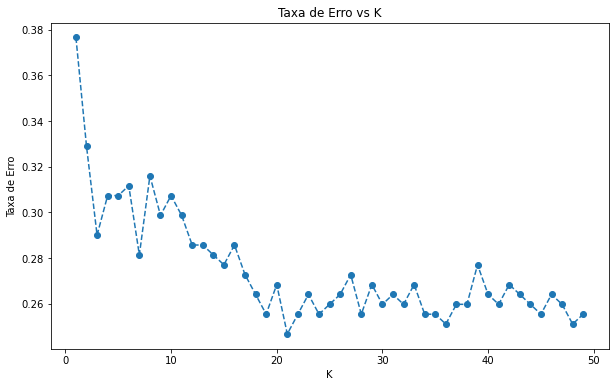

In [42]:
plt.figure(figsize=(10,6))
plt.plot(range(1,50), taxa_de_erro, linestyle='--', marker='o')
plt.title('Taxa de Erro vs K')
plt.xlabel('K')
plt.ylabel('Taxa de Erro')

Com o gráfico acima, conseguimos facilmente ver que partimos de um erro consideravelmente maior em K=1 e nosso erro foi caindo conforme aumentávamos o valor de K. Observando o gráfico, parece que conseguimos o menor erro com K em 42, então esse será o valor de K que escolheremos para classificar o nosso modelo!

In [43]:
# Só vou plotar o modelo com K=1 para efeitos de comparação: 

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)
print('Matriz de confusão com K=1:')
print(confusion_matrix(y_test,pred))
print('\n')
print('Relatório de modelo com K=1:')
print(classification_report(y_test,pred))

Matriz de confusão com K=1:
[[108  43]
 [ 44  36]]


Relatório de modelo com K=1:
              precision    recall  f1-score   support

           0       0.71      0.72      0.71       151
           1       0.46      0.45      0.45        80

    accuracy                           0.62       231
   macro avg       0.58      0.58      0.58       231
weighted avg       0.62      0.62      0.62       231



In [44]:
# Só vou plotar o modelo com K=21 para efeitos de comparação: 

knn = KNeighborsClassifier(n_neighbors=21)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)
print('Matriz de confusão com K=35:')
print(confusion_matrix(y_test,pred))
print('\n')
print('Relatório de modelo com K=35:')
print(classification_report(y_test,pred))

Matriz de confusão com K=35:
[[132  19]
 [ 38  42]]


Relatório de modelo com K=35:
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       151
           1       0.69      0.53      0.60        80

    accuracy                           0.75       231
   macro avg       0.73      0.70      0.71       231
weighted avg       0.75      0.75      0.74       231



# Conclusão:

Veja que com o K=21 nosso modelo foi consideravelmente melhor do que com K=1! E esse valor pode ir variando conforme o seu caso, basta ir explorando a base e realizando diferentes testes até chegar em um modelo que atenda as suas necessidades ou que você se sinta satisfeito!

Neste notebook, espero ter conseguido deixar claro pra você como que funciona o algoritmo do KNN e como conseguir aplicá-lo. Sinta-se à vontade para entrar em contato comigo via Reddit em casos de sugestão ou de dúvidas!

Criado por:

**u/_jvsm**